## Importing the Required Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import sys
import matplotlib.pyplot as plt
import nltk
import gensim
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from gensim import corpora
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud
from string import punctuation
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.colors as mcolors
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
tweets = pd.read_csv('vaccination_tweets.csv')

In [3]:
#Cleaning Tweets
stop_nltk= stopwords.words("english")
stop_updated= stop_nltk+["https",'t.co','...']
lemm= WordNetLemmatizer()
tweet_tok=  TweetTokenizer()

def clean_text(text):
    tokens= tweet_tok.tokenize(text.lower())
    tokens1 = [re.sub(r'^https://t.co/[\w]+','',tok) for tok in tokens]
    tokens2 = [re.sub(r'^@[\w]+','',tok) for tok in tokens1]
    tokens3 = [re.sub(r'^#[\w]+','',tok) for tok in tokens2]
    tokens4 = [re.sub(r'[0-9]+','',tok) for tok in tokens3]
    lemmed=[lemm.lemmatize(term) for term in tokens4 if term not in  stop_updated and term not in list(punctuation) and len(term)>2]
    res=' '.join(lemmed)
    return res

In [4]:
tweets['Clean_Tweets']= tweets['text'].apply(clean_text)

## Topic Modelling

In [5]:
clean_txt = [text.split() for text in tweets['Clean_Tweets'].to_list()]

# Creating the term dictionary of corpus
dictionary = corpora.Dictionary(clean_txt)

#Creating DTM
doc_term_matrix = [dictionary.doc2bow(doc) for doc in clean_txt]

# Running and Trainign LDA model on the document term matrix.
ldamodel = LdaModel(doc_term_matrix, num_topics=3, id2word = dictionary,
                    passes=50, 
                    random_state=42)
ldamodel.print_topics(num_words=20)

[(0,
  '0.026*"vaccine" + 0.018*"dose" + 0.010*"second" + 0.009*"arm" + 0.009*"side" + 0.009*"effect" + 0.007*"first" + 0.007*"hour" + 0.007*"day" + 0.006*"get" + 0.006*"health" + 0.006*"vaccinated" + 0.006*"one" + 0.005*"said" + 0.005*"emergency" + 0.005*"got" + 0.005*"post" + 0.005*"vaccination" + 0.005*"covid" + 0.004*"given"'),
 (1,
  '0.024*"vaccine" + 0.013*"new" + 0.012*"ban" + 0.011*"khamenei" + 0.010*"announced" + 0.010*"work" + 0.008*"red" + 0.008*"say" + 0.008*"crescent" + 0.008*"covid" + 0.007*"death" + 0.007*"year" + 0.007*"take" + 0.006*"import" + 0.006*"scientist" + 0.006*"vaccination" + 0.005*"effective" + 0.005*"people" + 0.005*"science" + 0.004*"variant"'),
 (2,
  '0.073*"vaccine" + 0.028*"covid" + 0.025*"first" + 0.018*"today" + 0.017*"pfizer" + 0.016*"dose" + 0.011*"dos" + 0.010*"received" + 0.010*"got" + 0.009*"get" + 0.009*"day" + 0.007*"people" + 0.007*"biontech" + 0.007*"use" + 0.007*"thank" + 0.006*"approved" + 0.006*"receive" + 0.006*"grateful" + 0.006*"pfizer

In [6]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 10);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict)

In [7]:
# Getting Top 10 words in each Document
get_lda_topics(ldamodel, 3)

,Topic # 01,Topic # 02,Topic # 03
0,vaccine,vaccine,vaccine
1,dose,new,covid
2,second,ban,first
3,arm,khamenei,today
4,side,announced,pfizer
5,effect,work,dose
6,first,red,dos
7,hour,say,received
8,day,crescent,got
9,get,covid,get


## Visualizaing the Topic clusters

In [8]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary=ldamodel.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.130485  0.110758       1        1  47.818810
0      0.045199 -0.153522       2        1  26.762447
1     -0.175685  0.042765       3        1  25.418741, topic_info=     Category        Freq         Term       Total  loglift  logprob
388   Default  194.000000        today  194.000000  30.0000  30.0000
63    Default  319.000000        first  319.000000  29.0000  29.0000
219   Default  282.000000         dose  282.000000  28.0000  28.0000
3832  Default   67.000000          ban   67.000000  27.0000  27.0000
3835  Default   65.000000     khamenei   65.000000  26.0000  26.0000
...       ...         ...          ...         ...      ...      ...
66     Topic3   28.689960       people  113.512253  -0.0057  -5.3051
144    Topic3   24.026718         week   84.114441   0.1167  -5.4825
428    Topic3   19.537302          way   35.702507   0.7668  -5.6893
118    Topic3   20.612692          get  161.730026  -0.6903  -5.6358
101    Topic3   19.299417  coronavirus   73.204750   0.0365  -5.7016

[188 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2377      2  0.954581         ache
412       3  0.982535    announced
2803      3  0.938491      appears
2072      2  0.973574  appointment
221       1  0.995043     approved
...     ...       ...          ...
292       1  0.980873       worker
17        1  0.294280         year
17        3  0.703003         year
820       1  0.405062    yesterday
820       2  0.582276    yesterday

[213 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

## Calculating Perplexity & Coherence

In [9]:
# Compute Perplexity
print('Perplexity: ', ldamodel.log_perplexity(doc_term_matrix))

# Compute Coherence
coherence_model_lda = CoherenceModel(model=ldamodel, texts=clean_txt, dictionary=ldamodel.id2word, coherence='c_v')
with np.errstate(invalid='ignore'):
    lda_score = coherence_model_lda.get_coherence()
print('Coherence Score: ', lda_score)

Perplexity:  -7.519221526609267
Coherence Score:  0.3119756573020392


## Dominant Topic Analysis

In [10]:
def format_topics_sentences(ldamodel=None, corpus=doc_term_matrix, texts=clean_txt):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=doc_term_matrix, texts=clean_txt)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9197,"vaccine, dose, second, arm, side, effect, firs...","[folk, said, daikon, paste, could, treat, cyto..."
1,1,1.0,0.6308,"vaccine, new, ban, khamenei, announced, work, ...","[world, wrong, side, history, year, hopefully,..."
2,2,2.0,0.8509,"vaccine, covid, first, today, pfizer, dose, do...","[russian, vaccine, created, last, year]"
3,3,0.0,0.9314,"vaccine, dose, second, arm, side, effect, firs...","[fact, immutable, senator, even, ethically, st..."
4,4,2.0,0.5936,"vaccine, covid, first, today, pfizer, dose, do...","[explain, need, vaccine]"
5,5,0.0,0.9242,"vaccine, dose, second, arm, side, effect, firs...","[anyone, useful, advice, guidance, whether, co..."
6,6,0.0,0.5541,"vaccine, dose, second, arm, side, effect, firs...","[bit, sad, claim, fame, success, patriotic, co..."
7,7,1.0,0.5521,"vaccine, new, ban, khamenei, announced, work, ...","[many, bright, day, best, winning]"
8,8,2.0,0.8258,"vaccine, covid, first, today, pfizer, dose, do...","[covid, vaccine, getting]"
9,9,2.0,0.6855,"vaccine, covid, first, today, pfizer, dose, do...","[state, start, getting, monday, say]"


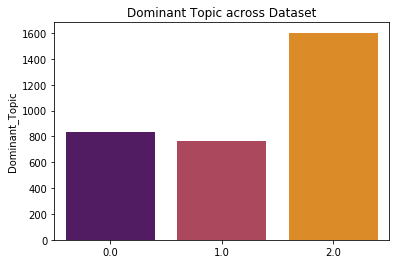

In [11]:
a = pd.DataFrame(df_dominant_topic['Dominant_Topic'].value_counts())
sns.barplot(a.index,a.Dominant_Topic, palette='inferno')
plt.title("Dominant Topic across Dataset")
plt.show()

## Frequency Distribution of Word Counts in Documents

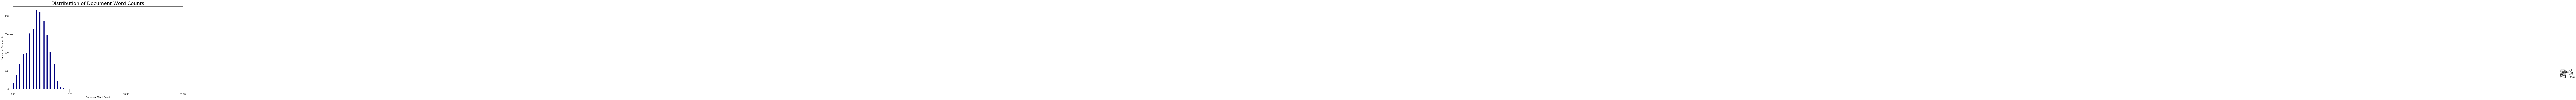

In [12]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(14,7))
plt.hist(doc_lens, bins = 50, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 50), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,50,4))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

## Top words in each Topic Cluster

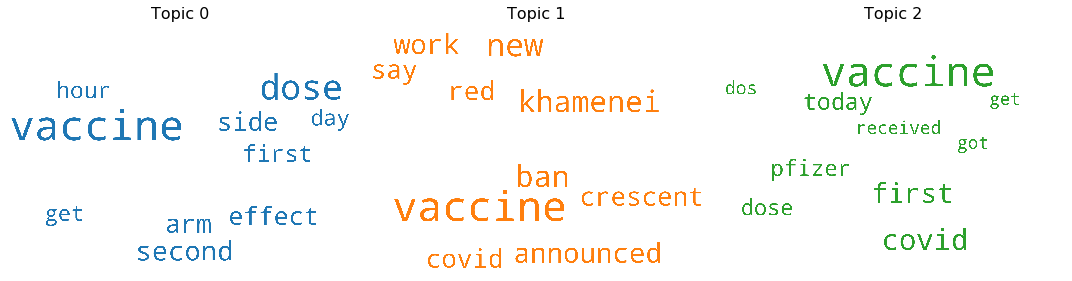

In [13]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='Spectral',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Topics wise Sentiment Analysis

In [14]:
# Conducting Sentiment Analysis to draw further Inference
analyser= SentimentIntensityAnalyzer() 

def get_vader_sentiment(sent):
    return analyser.polarity_scores(sent)['compound']

tweets['sent_vader']= tweets['Clean_Tweets'].apply(get_vader_sentiment)

sent_pred=[]
for i in range(len(tweets['sent_vader'])):
    if tweets['sent_vader'][i]>=0.05:
        sent_pred.append('positive')
    elif tweets['sent_vader'][i]<=-0.05:
        sent_pred.append('negative')
    else:
        sent_pred.append('neutral')  

tweets['sent_pred']= sent_pred
merge1 = pd.concat([df_dominant_topic,tweets[['sent_pred','sent_vader']]],axis=1)
m1 = pd.DataFrame(merge1.groupby(['Dominant_Topic','sent_pred'])['Text'].count())

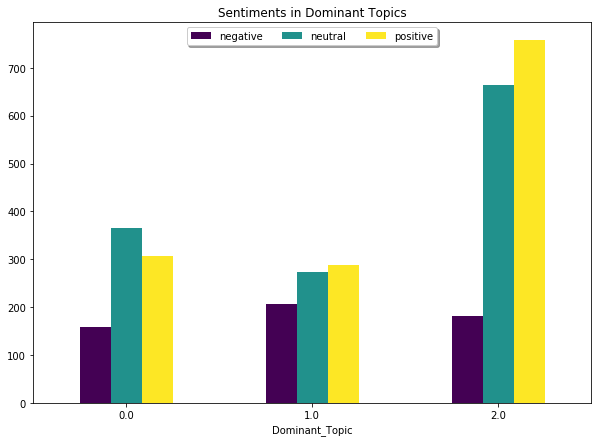

In [15]:
cross_tab= pd.crosstab(index=merge1['Dominant_Topic'],columns=merge1['sent_pred'])
cross_tab.plot(kind='bar', figsize=(10,7), colormap="viridis")
plt.xticks(rotation=0)
plt.title("Sentiments in Dominant Topics")
ax= plt.subplot(111)
ax.legend(loc="upper center",bbox_to_anchor=(00.5,1.00),ncol=4,fancybox=True,shadow=True)

## Conclusion

* Analysing the Topic Cluster, 
  - Cluster-1 has a positive outlook with terms such as 'grateful', 'good', 'thanks' & 'received' 
  - Cluster-2 has a concerned outlook with terms such as 'emergency', 'injection', 'sore' & 'health'
  - Cluster-3 has a negative outlook with terms such as 'ban', 'red', 'death', 'mutation', 'protect' & 'please'
  
*  Most Tweets belong to Cluster-1, Cluster-2 & Cluster-3 (descending order) 

* It is seen that percentage of positive sentiment tweet is highest in Cluster-1 justifying the positive outlook in the Tweets topics

* In Cluster-2, Neutral statement Tweets are highest

* In Cluster-3, it is seen thet in comparison to other two Topic Clusters, the number or count of Negative sentiment Tweets in highest Cluster -3 with 207 tweets